<a href="https://colab.research.google.com/github/Alice049/ml/blob/main/%E6%B7%B7%E6%93%AC%E5%9C%9FcsMPa%E8%B3%87%E6%96%99%E9%9B%86_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

多層感知器MLP
介於輸入與輸出層之間進行運算的中間層被稱為隱藏層
主要是使用者只關心可見的輸入與輸出層關心
二來是從仿生訊息系統的角度來看MLP,中間層的神經元既非輸入的可觀測變數，也非對外的輸出神經元，它們只跟其他神經元進行訊息傳遞溝通。因此稱為隱藏式神經元。
MLP因為訊息從前端傳遞到輸出，因此它是前向式網路，前向式網路預設的結構假設各層所有節點，會連接到下一層所有節點，滿足這個條件者稱為完全連通層。因此一但定義好層數跟各層神經元的個數後，MLP架構就完成。最後只剩下最佳化損失函數有關的輸出神經元了。
而層數跟神經元個數值兩者都取決於神經網路要解決的問題。以二元分類法來說，損失函數常用的有與Sigmoid輸出神經元搭配的二元交叉熵損失函數。
確定損失函數後，多層感知器常以倒傳遞算法訓練權重，
1.設定人工神經網路的基本結構和初始參數值：
   隱藏層層數和各層神經元數
   初始化隱藏層和輸出層內所有神經元的權重係數與偏差係數
   所有神經元使用的活化函數
2.將樣本自變數輸入類神經網路，進行前向傳遞
3.根據樣本前向傳遞的結果，計算與實際目標變數的誤差以及損失函數值，根據損失函數與各個權重的偏導函數關係，從輸出層法向往前傳播，不斷調整各神經元的權重係數與偏差量，最後獲得修正後的權重係數和係數，此步驟中計算偏導函數的過程稱為反向傳遞，
4.重複以上前向傳遞與反向傳遞步驟，依序使用訓練集中的樣本數據，參照修正參數。最後根據預設的終止條件停止學習，輸出最終的人工神經網路模型。
複雜的網路模型，訓練資料集可以重複使用，不因訓練資料用盡而停止學習，訓練集每完整遍歷一遍，就是完成一個世代的訓練。

In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

從Kaggle下載分享的資料“/kaggle/input/yeh-concret-data/Concrete_Data_Yeh.csv”
以R語言讀入混擬土的配方和強度資料

In [3]:
concrete<-read.csv("/content/Concrete_Data_Yeh.csv")
str(concrete)

'data.frame':	1030 obs. of  9 variables:
 $ cement          : num  540 540 332 332 199 ...
 $ slag            : num  0 0 142 142 132 ...
 $ flyash          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ water           : num  162 162 228 228 192 228 228 228 228 228 ...
 $ superplasticizer: num  2.5 2.5 0 0 0 0 0 0 0 0 ...
 $ coarseaggregate : num  1040 1055 932 932 978 ...
 $ fineaggregate   : num  676 676 594 594 826 ...
 $ age             : int  28 28 270 365 360 90 365 28 28 28 ...
 $ csMPa           : num  80 61.9 40.3 41 44.3 ...


類神經網路對資料相當敏感，數據輸入網路訓練前，需要正規化數據為0與1之間的數值。

In [4]:
#正規化
normalize<-function(x){
    return((x-min(x))/(max(x)-min(x)))
}
#運用隱式迴圈函數逐欄正規劃後，將等長的資料轉為資料框
concrete_norm<-as.data.frame(lapply(concrete,normalize))

In [5]:
#轉換前後的資料值
summary(concrete$csMPa)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.33   23.71   34.45   35.82   46.13   82.60 

In [6]:
summary(concrete_norm$csMPa)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2664  0.4001  0.4172  0.5457  1.0000 

In [7]:
#訓練與測試資料的分切
concrete_train<-concrete_norm[1:750,]
concrete_test<-concrete_norm[751:1030,]

{neuralnet}套件
訓練單一隱藏層類神經網路，與套件同名的neuralnet()有許多引述可設定類神經網路結構與訓練方式
hidden為個隱藏層神經元個數所形成的整數向量值，預設為1
threshold停止學習的誤差片導函數門檻值，預設0.01
stepmax停止學習的最大迭代次數，預設為100000
rep類神經網路訓練的重複次數，或稱世代，預設為1
startweights權重向量初始值，預設為null
learningrate.limit最低與最高學習率形成的向量或串列,用於彈性到傳遞算法
learningrate.factor學習率上下屆的乘數因子向量或串列，預設為list
learningrate用於傳統倒傳遞算法
lifesign訓練期間訊息回報量，預設為“none"
lifesign.step當lifesign為“”full時，訊息回報的間格步數，預設為1000
algorithm類神經網路訓練算法,預設為“rprop+"
err.fct計算誤差的可微分函數，預設為“sse",另一個誤差計算損失函數是“ce"
act.fct活化函數，預設為“logitic”
linear.output當act.fct活化函數不應用於輸出神經元時，則預設TRUE
constant.weights訓練過程視為固定的權重值，預設為NULL
likelihood誤差函數是否為負的對數概似函數，且信賴區間有意義，預設值為FALSE

In [8]:
#載入套件
install.packages("neuralnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Deriv’




In [12]:
#載入相關套件
install.packages("Deriv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [14]:
library(Deriv)

In [42]:
library(neuralnet)
concrete_model<-neuralnet(formula = csMPa ~ cement + slag + flyash + water + superplasticizer + coarseaggregate + fineaggregate + age , data=concrete_train)

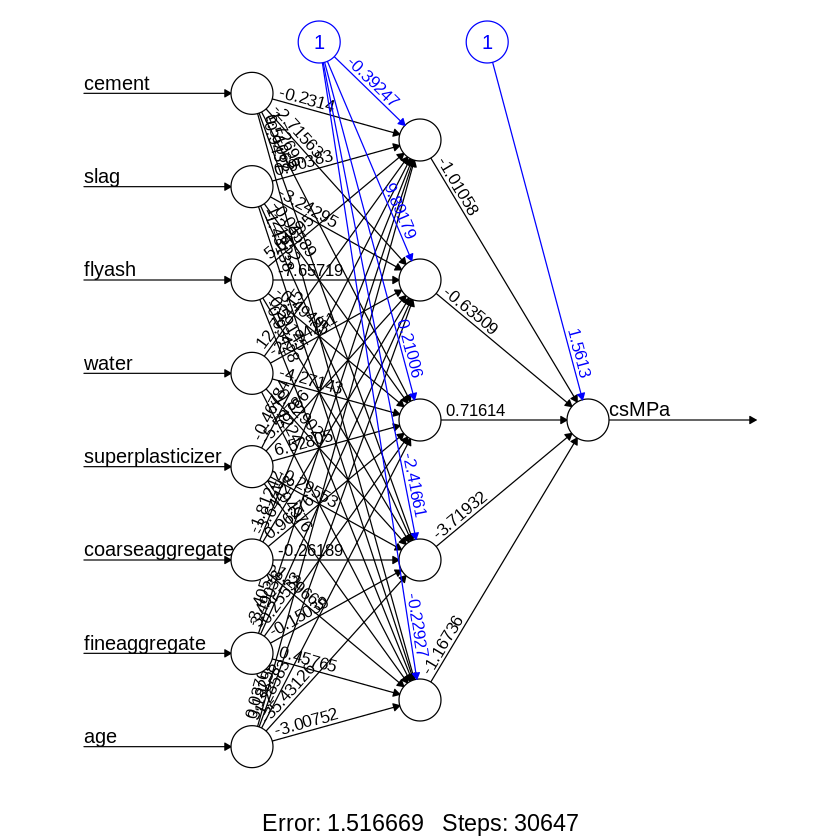

In [41]:
#網路拓樸視覺化
plot(concrete_model,rep = "best")

In [18]:
#以測試集評估模型績效
model_results<-compute(concrete_model,concrete_test[1:8])
predicted_strength<-model_results$net.result
#預測集前六筆預測值
head(predicted_strength)

751,0.5322381
752,0.5331029
753,0.5573715
754,0.5959928
755,0.6634750
756,0.6737985


In [19]:
#檢視混擬土強度預測值與真實值得相關係數
cor(predicted_strength,concrete_test$csMPa)

0.7515228


In [35]:
#強度預測值與實際值的最大最小值
axisRange<-extendrange(c(concrete_test$csMPa,predicted_strength))
axisRange

[1] 0.006278809 0.948000498

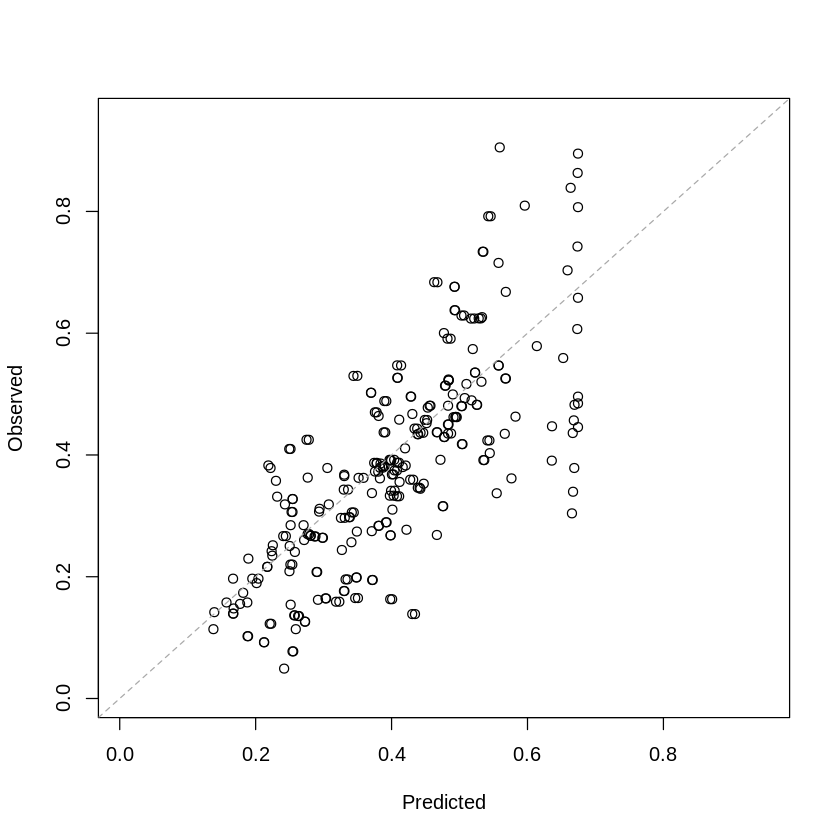

In [33]:
#在預測值與實際值散佈範圍中繪製散布圖
plot(concrete_test$csMPa ~ predicted_strength,ylim=axisRange,xlim=axisRange, xlab="Predicted" ,ylab="Observed")
abline(0,1,col='darkgrey',lty=2)

改善模型
將隱藏層神經元增加到5個，結果顯示出預測值和真實值的相關係數

In [36]:

concrete_model2<-neuralnet(formula =csMPa ~ cement + slag + flyash + water + superplasticizer + coarseaggregate + fineaggregate + age,data=concrete_train,hidden=5)

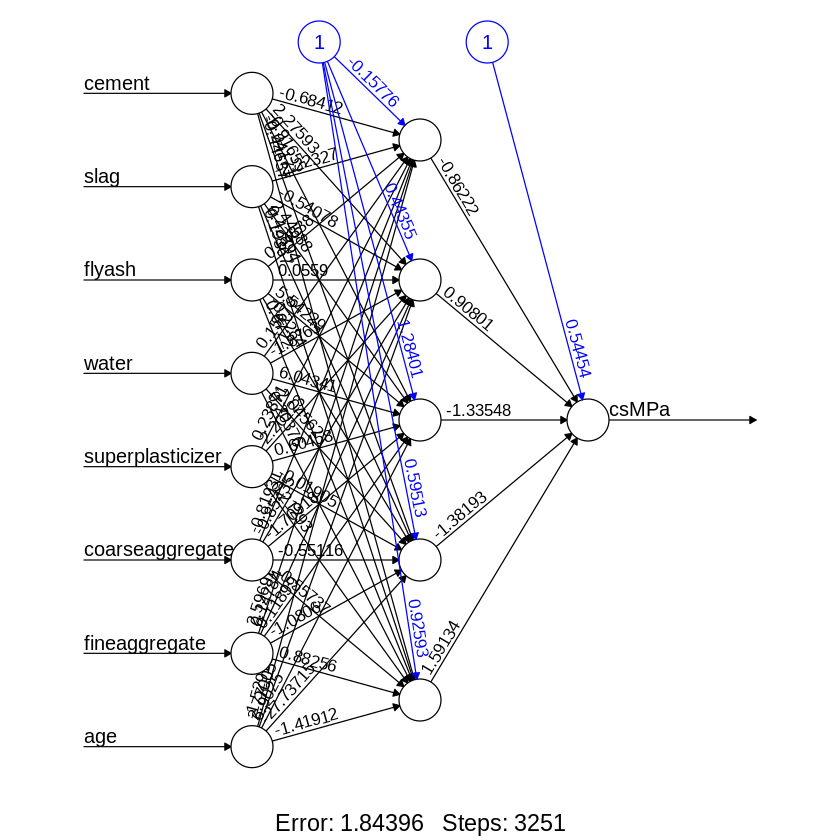

In [37]:
plot(concrete_model2,rep="best")

In [38]:
model_results2<-compute(concrete_model2,concrete_test[1:8])
predicted_strength2<-model_results2$net.result
cor(predicted_strength2,concrete_test$csMPa)

0.6464012


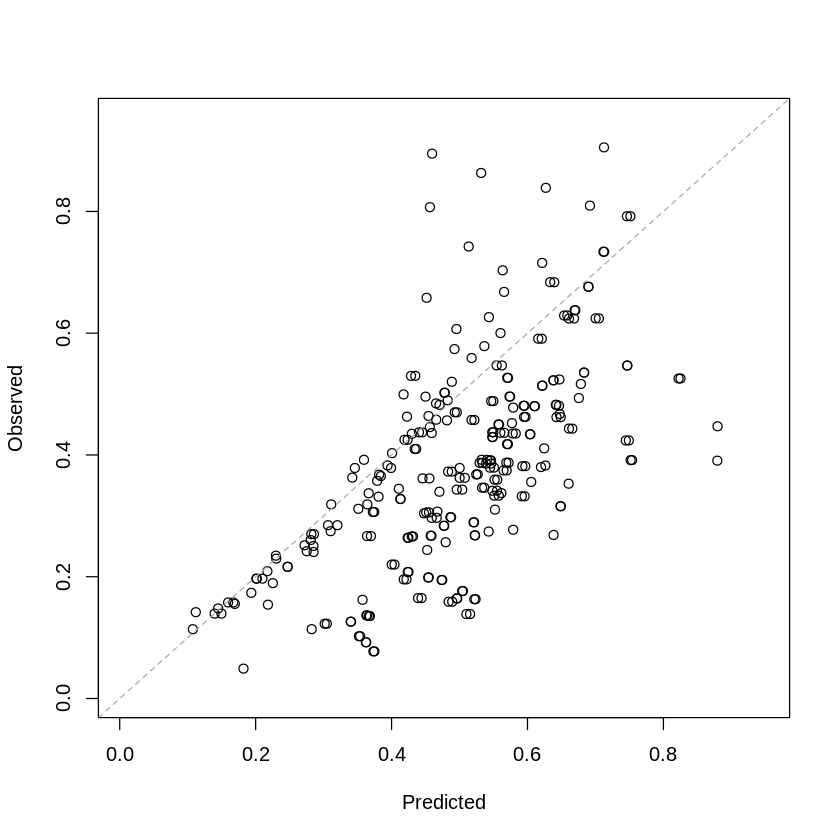

In [39]:
#實際值對預測值散佈圖
axisRange<-extendrange(c(concrete_test$csMPa,predicted_strength2))
plot(concrete_test$csMPa ~ predicted_strength2,ylim=axisRange,xlim=axisRange,xlab="Predicted",ylab="Observed")
abline(0,1,col='darkgrey',lty=2)